In [1]:
from matplotlib import pyplot as plt
import numpy as np
import random
from typing import Callable

MIN: int = 0
MAX: int = 4
BINS: int = 100
NUM_SAMPLES: int = 100000
N: int = 5

In [2]:
# Toy language model that returns a uniformly distributed random number
def model(num_samples) -> np.ndarray:
    return np.random.uniform(0, MAX, num_samples)

def histogram(output: list[int]):
    hist, bins = np.histogram(output, bins=BINS, range=(MIN, MAX), density=False)
    probs = hist / np.sum(hist)
    return probs, bins

In [20]:
# The ground truth reward model. We assume that we have a preference for the number `mid`.
def reward_model_ground_truth(output) -> float:
    # 5 - abs(2 - x)
    return 5 - abs(2 - output)

# Definition of the proxy reward model. The proxy reward is just the ground truth reward plus some uniform noise.
def reward_model_proxy(output) -> float:
    gt = reward_model_ground_truth(output)
    noise = 2
    x = output
    if (x >=0 and x <= 0.01) or (x >= 3.99 and x <= 4):
        gt += noise
    return gt

In [15]:
def best_of_n(n: int, reward_model):
    outputs = model(n)
    rewards = [reward_model(output) for output in outputs]
    best_output = outputs[np.argmax(rewards)]
    best_reward = np.max(rewards)
    return best_output, best_reward


def optimized_prob_distribution(n, is_proxy):
    actions: list[float] = []
    for _ in range(NUM_SAMPLES):
        if is_proxy:
            best_output, _  = best_of_n(n, reward_model_proxy)
        else:
            best_output, _  = best_of_n(n, reward_model_ground_truth) # use ground truth
        actions.append(best_output)
    probs, bins = histogram(actions)
    return probs, bins


def plot_optimized_output() -> None:
    plt.hist(bins[:-1], bins, weights=probs_optimized)
    plt.xlabel("output")
    plt.ylabel("prob(output)")

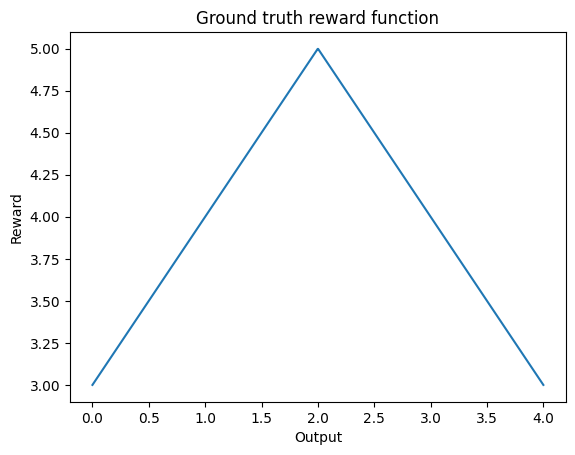

In [9]:
# plot the reward function
outputs = np.linspace(MIN, MAX, 1000)
rewards_ground_truth = [reward_model_ground_truth(output) for output in outputs]
plt.plot(outputs, rewards_ground_truth)
plt.xlabel("Output")
plt.ylabel("Reward")
plt.title("Ground truth reward function")
plt.savefig("ground_truth_reward_function.png")
plt.show()

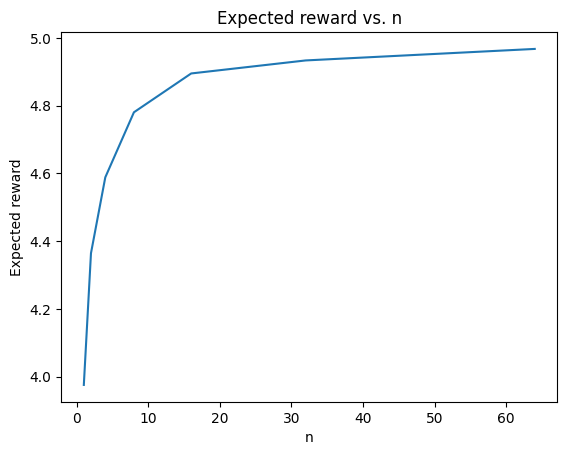

In [19]:
Ns = [1, 2, 4, 8, 16, 32, 64]
trials = 100
rng = np.random.default_rng(12345)

# plot Expected(Reqard(BoN))
output = []
for n in Ns:
    rewards = []
    for _ in range(trials):
        best_output, best_reward = best_of_n(n, reward_model_ground_truth)
        rewards.append(best_reward)
    expected_reward = np.mean(rewards)
    output.append((n, expected_reward))

plt.plot([x[0] for x in output], [x[1] for x in output])
plt.xlabel("n")
plt.ylabel("Expected reward")
plt.title("Expected reward vs. n")
plt.savefig("expected_reward_vs_n.png")
plt.show()

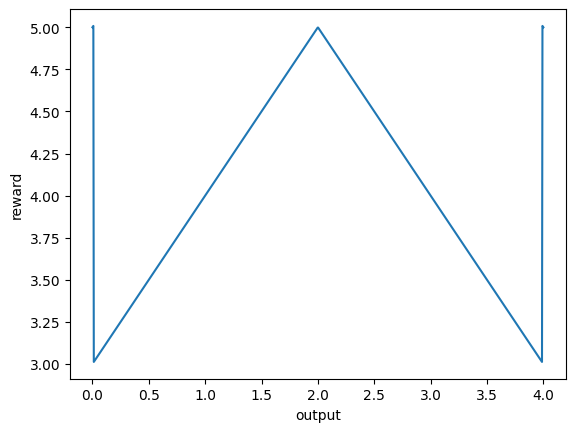

In [26]:
def plot_rewards() -> None:
    outputs = np.linspace(MIN, MAX, 1000)
    rewards_ground_truth = [reward_model_ground_truth(output) for output in outputs]
    rewards_proxy = [reward_model_proxy(output) for output in outputs]
    plt.plot(outputs, rewards_proxy, alpha=1.0)
    # plt.plot(outputs, rewards_ground_truth, alpha=1.0)
    plt.xlabel("output")
    plt.ylabel("reward")

# Plot the proxy and ground truth rewards
plot_rewards()
plt.savefig("proxy_reward_function.png")
plt.show()

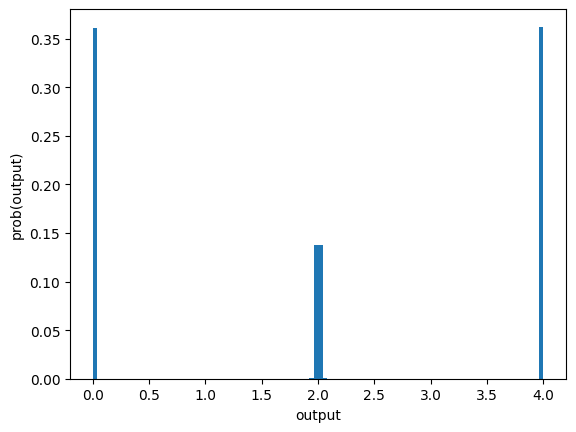

In [27]:
# Probabilities before best-of-n sampling
probs_initial: list[int] = BINS * [1/BINS]

# Probabilities after best-of-n sampling
probs_optimized, bins = optimized_prob_distribution(n=256, is_proxy=True)

# Plot the output after best-of-n sampling using the proxy reward model
plot_optimized_output()

In [30]:
# The KL divergence for best-of-n sampling can be computed analytically, see page 31 https://arxiv.org/pdf/2009.01325.pdf
def kl_divergence_analytical(n):
    res = np.log(n) - ((n-1) / n)
    return res

def kl_divergence_numerical(p, q):
    pass

# The KL divergence between the initial distribution and the optimized distribution increases with n
for n in [2, 4, 8, 16, 32, 64, 128, 256]:
    probs_initial: list[int] = BINS * [1/BINS]
    probs_optimized, bins = optimized_prob_distribution(n=n, is_proxy=True)
    kl_divergence = kl_divergence_analytical(n)
    print(f"n={n}, kl_divergence={kl_divergence}")

n=2, kl_divergence=0.1931471805599453
n=4, kl_divergence=0.6362943611198906
n=8, kl_divergence=1.2044415416798357
n=16, kl_divergence=1.8350887222397811
n=32, kl_divergence=2.4969859027997265
n=64, kl_divergence=3.1745080833596715
n=128, kl_divergence=3.859842763919617
n=256, kl_divergence=4.549083694479562


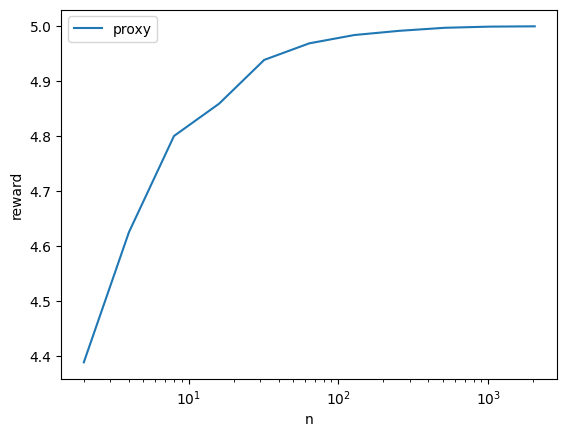

In [31]:
def estimate_reward(n:int, reward_model: Callable) -> float:
    trials = 100
    expected_rewards = []
    for _ in range(trials):
        best_output, best_reward = best_of_n(n, reward_model)
        expected_rewards.append(best_reward)
    expected_reward = np.mean(expected_rewards)
    return expected_reward

rewards_ground_truth: list[float] = []

RANGE_N: list[int] = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
for n in RANGE_N:
    reward_ground_truth: float = estimate_reward(n, reward_model_ground_truth)
    rewards_ground_truth.append(reward_ground_truth)

# Plot proxy vs. ground truth rewards
# With uniform random noise, the proxy as well as the ground truth reward are monotonically increasing
# But thats not the case when using a real instead of a toy reward model, see https://arxiv.org/pdf/2210.10760.pdf
plt.plot(RANGE_N, rewards_ground_truth)
plt.xscale('log')
plt.ylabel('reward')
plt.xlabel('n')
plt.legend(['proxy', 'ground truth'])
plt.show()

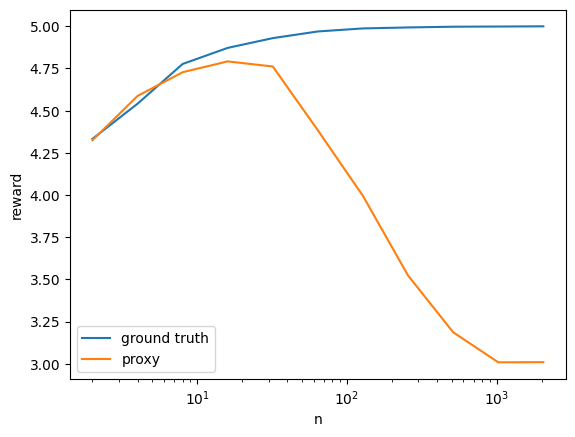

In [38]:
# why not using very large n?


def estimate_reward(n:int, reward_model: Callable) -> float:
    trials = 100
    expected_rewards_gt = []
    expected_rewards_proxy = []
    for _ in range(trials):
        best_output_gt, best_reward_gt = best_of_n(n, reward_model_ground_truth)
        best_output_proxy, _ = best_of_n(n, reward_model)
        best_reward_proxy = reward_model_ground_truth(best_output_proxy)
        expected_rewards_gt.append(best_reward_gt)
        expected_rewards_proxy.append(best_reward_proxy)
    return np.mean(expected_rewards_proxy), np.mean(expected_rewards_gt)

rewards_ground_truth: list[float] = []
rewards_proxy: list[float] = []

RANGE_N: list[int] = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
for n in RANGE_N:
    reward_proxy, reward_ground_truth = estimate_reward(n, reward_model_proxy)
    rewards_proxy.append(reward_proxy)
    rewards_ground_truth.append(reward_ground_truth)

# Plot proxy vs. ground truth rewards
# With uniform random noise, the proxy as well as the ground truth reward are monotonically increasing
# But thats not the case when using a real instead of a toy reward model, see https://arxiv.org/pdf/2210.10760.pdf
plt.plot(RANGE_N, rewards_ground_truth)
plt.plot(RANGE_N, rewards_proxy)
plt.xscale('log')
plt.ylabel('reward')
plt.xlabel('n')
plt.legend(['ground truth', 'proxy'])
plt.savefig("proxy_vs_ground_truth_reward.png")
plt.show()